In [2]:
%matplotlib inline

#from NNDefs import build_and_train_class_nn
from LayersDefs import get_signal_and_background_frames, calculate_derived_et_columns, roc_cuts, background_eff_at_target_signal_eff, manual_train_1d, min_manual_eff_1d
#from sklearn.model_selection import train_test_split
import math
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter

Welcome to JupyROOT 6.14/02


In [3]:
signal_frame, background_frame = get_signal_and_background_frames()

all_frame = pd.concat([signal_frame, background_frame], sort=True)

In [4]:
calculate_derived_et_columns(signal_frame, background_frame)

calculate_derived_et_columns(signal_frame, background_frame, layer_weights=[1, 1, 1, 1], column_names=['L0Et', 'L1Et', 'L2Et', 'L3Et'],
                                     output_column_name='EMEt')

calculate_derived_et_columns(signal_frame, background_frame, layer_weights=[1, 1], column_names=['L0Et', 'L1Et'],
                             output_column_name='L0+L1Et')

calculate_derived_et_columns(signal_frame, background_frame, layer_weights=[1, 1], column_names=['L2Et', 'L3Et'],
                             output_column_name='L2+L3Et')

# Calculate 3 layer with minimum weights
calculate_derived_et_columns(signal_frame, background_frame, layer_weights=[1, 1.3, 8.4], column_names=['L0+L1Et', 'L2+L3Et', 'HadEt'],
                             output_column_name='3LayerWeightedEt')

In [5]:
no_had_sig = signal_frame[signal_frame['HadEt'] == 0].copy()
no_had_back = background_frame[background_frame['HadEt'] == 0].copy()

some_had_sig = signal_frame[signal_frame['HadEt'] != 0].copy()
some_had_back = background_frame[background_frame['HadEt'] != 0].copy()

In [7]:
print(len(no_had_sig) / len(signal_frame))
print(len(some_had_sig) / len(signal_frame))
print(len(no_had_back) / len(background_frame))
print(len(some_had_back) / len(background_frame))

0.5348209906817067
0.46517900931829326
0.9493403235383568
0.05065967646164318


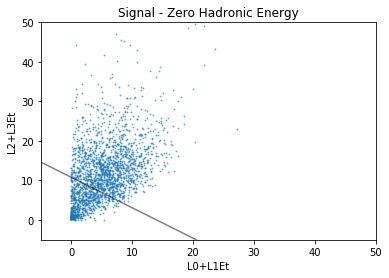

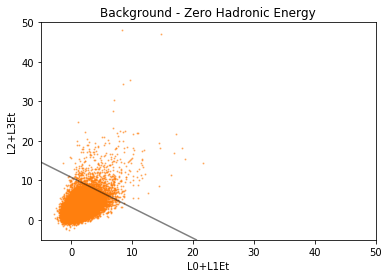

In [75]:
plt.scatter(no_had_sig[['L0+L1Et']], no_had_sig[['L2+L3Et']], 1, label='Signal', alpha=0.5)
plt.plot([-5, 20.54], [14.65, -5], color='k', alpha=0.5)
plt.xlim([-5, 50])
plt.ylim([-5, 50])
plt.title('Signal - Zero Hadronic Energy')
plt.xlabel('L0+L1Et')
plt.ylabel('L2+L3Et')
plt.show()
plt.scatter(no_had_back[['L0+L1Et']], no_had_back[['L2+L3Et']], 1, label='Background', alpha=0.5, color='C1')
plt.plot([-5, 20.54], [14.65, -5], color='k', alpha=0.5)
plt.xlim([-5, 50])
plt.ylim([-5, 50])
plt.title('Background - Zero Hadronic Energy')
plt.xlabel('L0+L1Et')
plt.ylabel('L2+L3Et')
plt.show()

In [52]:
# Determine percentage of no had signal to cut away to achieve 90% signal overall
target_no_had_eff = .9 - .1 * (len(some_had_sig) / len(no_had_sig))

# Create weights to test
weights = [i * 0.1 for i in range(101)]

# Calculate background efficiency at target efficiency for each weight scenario
background_efficiencies = manual_train_1d(no_had_sig, no_had_back, ['L0+L1Et', 'L2+L3Et'], weights, target_eff=target_no_had_eff)

# Find weight that achieves the minimum background efficiency at target signal efficiency
min_eff, min_weight = min_manual_eff_1d(background_efficiencies, weights)
print(min_eff, min_weight)
print(background_efficiencies[13], weights[13])

0.07948009946453906 2.3000000000000003
0.07995301368400178 1.3


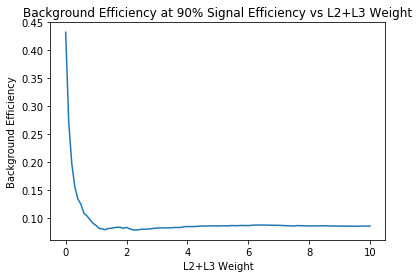

In [54]:
plt.plot(weights, background_efficiencies)
plt.title('Background Efficiency at 90% Signal Efficiency vs L2+L3 Weight')
plt.xlabel('L2+L3 Weight')
plt.ylabel('Background Efficiency')
plt.show()

In [28]:
print(target_no_had_eff)
print((.07995 * len(no_had_back) + len(some_had_back)) / len(background_frame))
print((target_no_had_eff * len(no_had_sig) + len(some_had_sig)) / len(signal_frame))

0.8130215497478221
0.1265594353285348
0.8999999999999999


In [ ]:
for i, j in zip(weights, background_efficiencies):
    print(i, j)

In [59]:
# Calculate derived weighted Et column with minimum weight applied
calculate_derived_et_columns(no_had_sig, no_had_back, layer_weights=[1, min_weight], column_names=['L0+L1Et', 'L2+L3Et'], output_column_name='NoHadWeighted')

cuts = [i * 0.5 for i in range(101)]

# Apply cuts on weighted Et column, returning event counts instead of efficiencies
sig_had_cuts, back_had_cuts = roc_cuts(no_had_sig[['NoHadWeighted']], no_had_back[['NoHadWeighted']], cuts=cuts, netcuts=200, return_efficiencies=False, target_90percent_signal=True)

# Add back in some had events to get total event counts after cutting on only no had
sig_all_cuts = [i + len(some_had_sig) for i in sig_had_cuts]
back_all_cuts = [i + len(some_had_back) for i in back_had_cuts]

In [60]:
sig_all_eff = [i / len(signal_frame) for i in sig_all_cuts]
back_all_eff = [i / len(background_frame) for i in back_all_cuts]

In [62]:
for i, j in zip(cuts, zip(sig_all_eff, back_all_eff)):
    print(i, j)

0.0 (1.0, 0.9913829309620704)
0.5 (1.0, 0.9865747512635954)
1.0 (0.9958312898479647, 0.9794348940607395)
1.5 (0.9901912702305051, 0.9684282176425437)
2.0 (0.9845512506130456, 0.9539312662022622)
2.5 (0.9754781755762629, 0.9333951252009443)
3.0 (0.9691025012260912, 0.9082101116598358)
3.5 (0.9641981363413438, 0.8774059001578589)
4.0 (0.9605198626777832, 0.842256947964489)
4.5 (0.9575772437469348, 0.8022418861967588)
5.0 (0.9553702795487984, 0.7577517415168938)
5.5 (0.9512015693967631, 0.7109444018016191)
6.0 (0.9497302599313389, 0.6616026300163652)
6.5 (0.9470328592447278, 0.611174673058263)
7.0 (0.9448258950465914, 0.5601818998102797)
7.5 (0.9411476213830309, 0.5113470144390215)
8.0 (0.9386954389406572, 0.4645251922547756)
8.5 (0.9359980382540461, 0.4205129690509638)
9.0 (0.933300637567435, 0.37752900114411503)
9.5 (0.9310936733692987, 0.3379339309765529)
10.0 (0.9288867091711623, 0.30191603064490435)
10.5 (0.9264345267287887, 0.2698808092803661)
11.0 (0.924717999019127, 0.241582064910

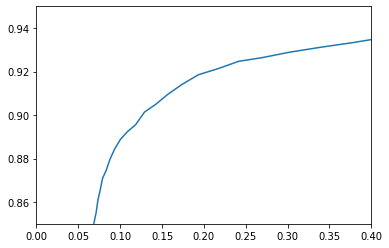

In [61]:
plt.plot(back_all_eff, sig_all_eff)
plt.xlim([0, 0.4])
plt.ylim([0.85, 0.95])
plt.show()

In [17]:
calculate_derived_et_columns(signal_frame, background_frame, layer_weights=[1, min_weight], column_names=['L0+L1Et', 'L2+L3Et'], output_column_name='NoHadWeighted')

signal_events = len(signal_frame)

# Find number of signal events that must be cut to fall below 90% efficiency
sig_events_to_cut = math.ceil(signal_events * 0.1)

# Sort signal by the column to be cut on
sorted_signal_et = signal_frame.sort_values(by=['HadEt', 'NoHadWeighted'])

# Find the cutoff Et that produces the 90% remaining signal efficiency
et_cutoff = sorted_signal_et.iloc[sig_events_to_cut - 1]['NoHadWeighted']

# Find the number of background events that survive the previously calculated Et cut
background_above_cutoff_each = [1 if row[1]['NoHadWeighted'] > et_cutoff or row[1]['HadEt'] > 0 else 0 for row in background_frame.iterrows()]
background_above_cutoff = sum(background_above_cutoff_each)

# Convert event number to efficiency
end_background_efficiency = background_above_cutoff / len(background_frame)
                                
print(end_background_efficiency)

0.1289808686584889


In [ ]:
counts = Counter(background_frame[background_frame['HadEt'] < 2]['HadEt'])
print(sorted(counts))
for i in sorted(counts):
    print(i, counts[i])